## Imports and dataset

In [1]:
from src.models.optimized_bnn import BayesianNN, BayesianNNVI
from src.utils2 import plot_ppds

from src.attacks.distr_attacks_bnn_jax import fgsm_attack, mlmc_attack, kl_to_appd

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
import numpyro
numpyro.set_host_device_count(8)

In [4]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

# Wine dataset

In [5]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [6]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [7]:
# Fit the model
model = BayesianNN(input_dim=X_train.shape[1], hidden_units=3)
try:
    model.load('../src/models/3bnn')
except FileNotFoundError:   
    print('Not model found, fitting the model') 
    model.fit(
        X_train, 
        y_train,
        num_warmup=500,
        num_samples=1000,
        num_chains=8,
    )
    model.save('../src/models/3bnn')

In [8]:
modelVI = BayesianNNVI(input_dim=X_train.shape[1], hidden_units=3)
try:
    modelVI.load('../src/models/3bnnvi')
except FileNotFoundError:
    print('Not model found, fitting the model') 
    modelVI.fit(
        X_train, 
        y_train, 
        num_steps=5000
    )
    modelVI.save('../src/models/3bnnvi')

#### appd = N(2mu, 2var)

In [37]:
# Attack example
x = X_test[17,:].copy().reshape(1, -1)
x = jnp.array(x)
std = modelVI.sample_predictive_distribution(x, 1000).std()
mu = modelVI.sample_predictive_distribution(x, 1000).mean()
appd = numpyro.distributions.Normal(2 + mu, 2 * std)
x_adv_distr, x_adv_values = mlmc_attack(model, x, appd=appd, epsilon=2, R=20, lr=0.005, n_iter=1000)

In [38]:
x_adv_distr

Array([[ 0.70856184,  0.12451801,  0.9105058 ,  0.13829605,  0.19619446,
         0.16699666,  0.05299629, -0.16231374,  0.42420924,  0.44094852,
         0.1336174 ]], dtype=float32)

(100000, 1)


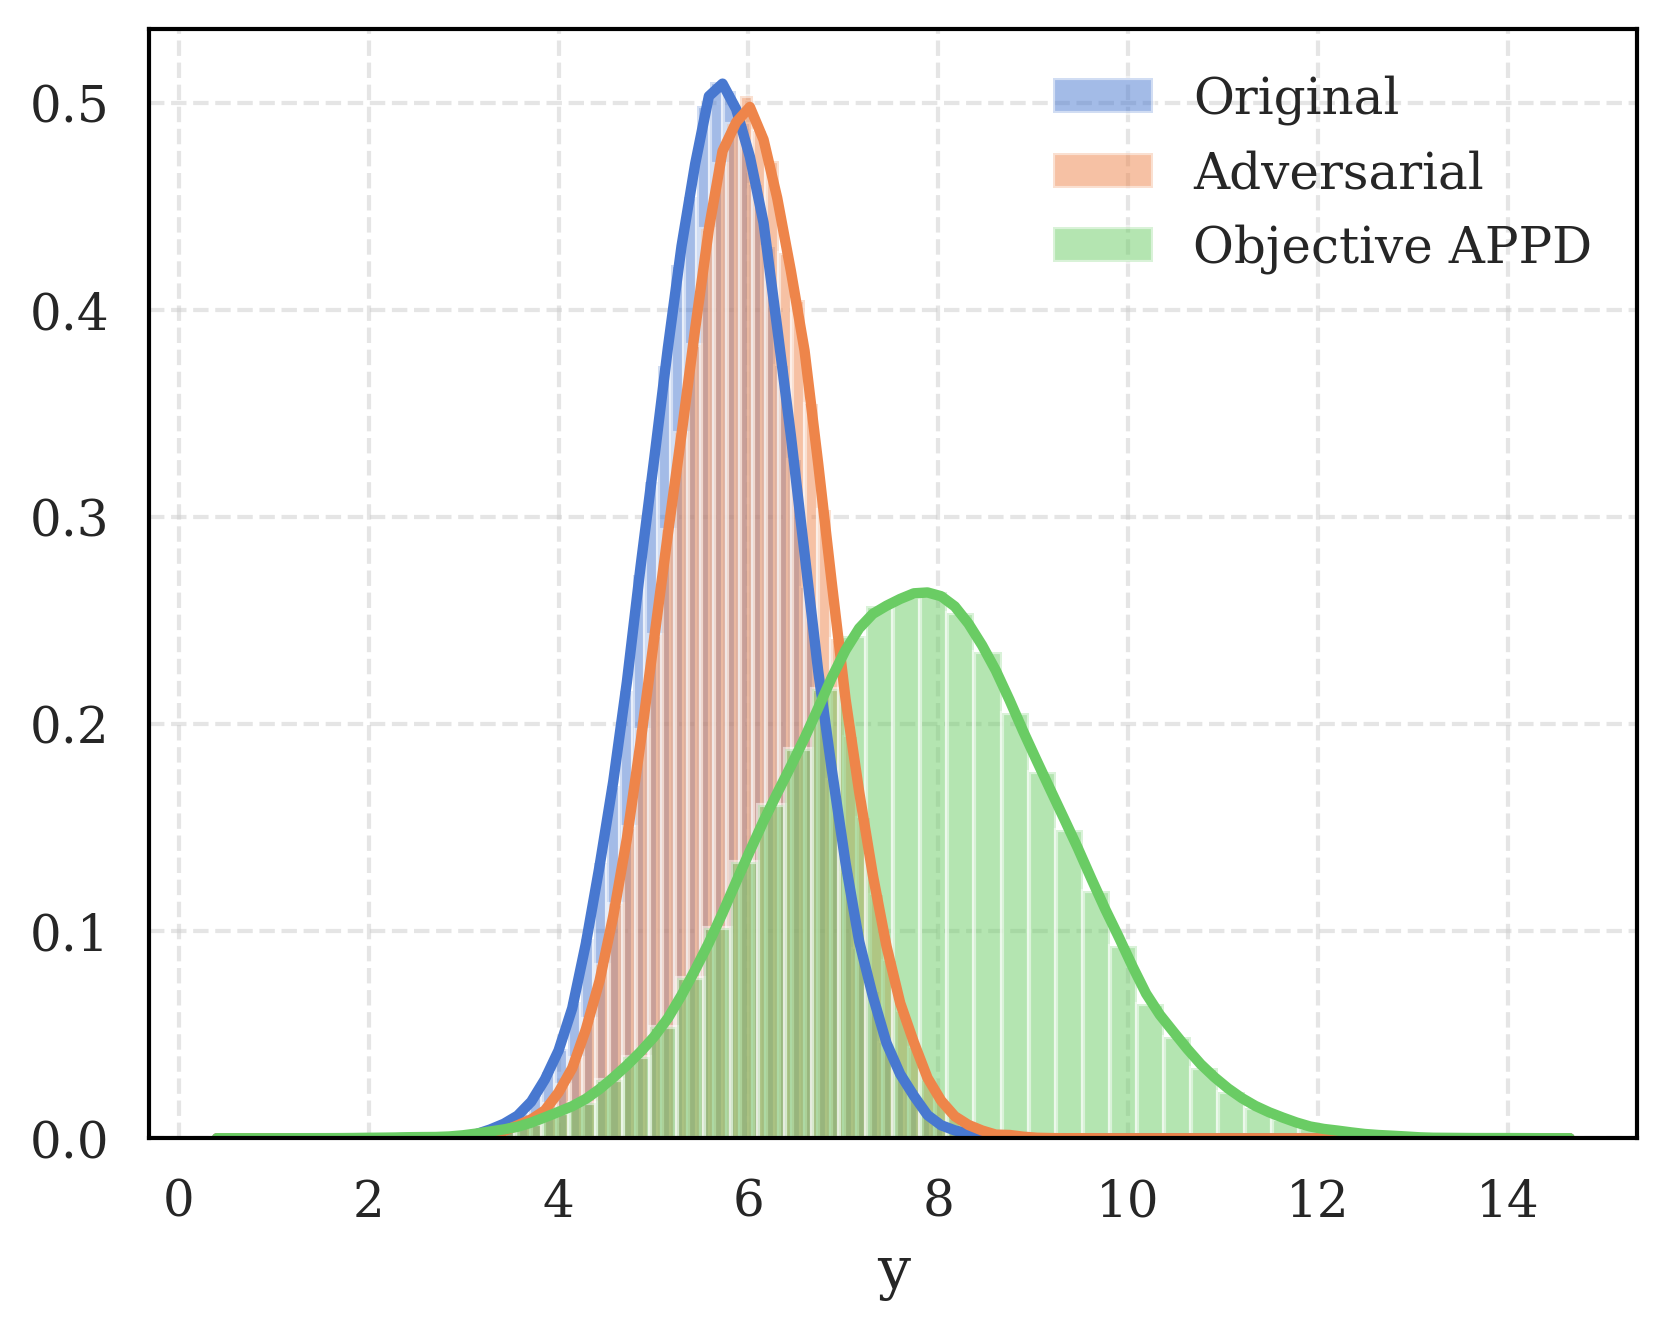

In [39]:
plot_ppds(modelVI, x, x_adv_distr, jax.random.PRNGKey(42), appd)

In [44]:
from tqdm import tqdm

In [ ]:
epsilons = [0, 0.2, 0.5]
results = []
for i in tqdm(range(10)):
    res_it_mm = []
    res_it_mvi = []
    res_it_vim = []
    res_it_vivi = []
    for epsilon in epsilons:
        def compute_kl(model, model_eval, i):
            x = X_test[i,:].copy().reshape(1, -1)
            x = jnp.array(x)
            std = model.sample_predictive_distribution(x, 1000).std()
            mu = model.sample_predictive_distribution(x, 1000).mean()
            appd = numpyro.distributions.Normal(2 * mu, 2 * std)
            if epsilon == 0:
                x_adv = x.clone()
            else:
                x_adv, _ = mlmc_attack(model, x, appd, epsilon=epsilon, verbose=False, R=20, lr=0.001, n_iter=2000)
            adv_std = model_eval.sample_predictive_distribution(x_adv, 1000).std()
            adv_mu = model_eval.sample_predictive_distribution(x_adv, 1000).mean()
            att_kl = kl_to_appd(adv_mu, adv_std ** 2, mu, std ** 2)
            return att_kl

        kl_values_mm = Parallel(n_jobs=-1)(delayed(compute_kl)(model, model, j) for j in range(X_test.shape[0]))
        kl_mm = sum(kl_values_mm)
        res_it_mm.append(kl_mm / X_test.shape[0])
        kl_values_mvi = Parallel(n_jobs=-1)(delayed(compute_kl)(model, modelVI, j) for j in range(X_test.shape[0]))
        kl_mvi = sum(kl_values_mvi)
        res_it_mvi.append(kl_mvi / X_test.shape[0])
        kl_values_vim = Parallel(n_jobs=-1)(delayed(compute_kl)(modelVI, model, j) for j in range(X_test.shape[0]))
        kl_vim = sum(kl_values_vim)
        res_it_vim.append(kl_vim / X_test.shape[0])
        kl_values_vivi = Parallel(n_jobs=-1)(delayed(compute_kl)(modelVI, modelVI, j) for j in range(X_test.shape[0]))
        kl_vivi = sum(kl_values_vivi)
        res_it_vivi.append(kl_vivi / X_test.shape[0])
    res_it = {
        'mm': res_it_mm,
        'mvi': res_it_mvi,
        'vim': res_it_vim,
        'vivi': res_it_vivi
    }
    results.append(res_it)

  0%|          | 0/10 [00:00<?, ?it/s]/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
